In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca637.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3400.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca783.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3927.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca4109.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca95.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca488.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca2140.jp

In [2]:
# Setup
!pip -q install imagehash tqdm

import os, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image
import imagehash
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
import matplotlib.pyplot as plt

print("TF:", tf.__version__)
SEED = 1337
rng = np.random.default_rng(SEED)

2025-08-12 16:48:23.509216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755017303.670531      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755017303.715009      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF: 2.18.0


In [3]:
# Paths and configuration
# Root folder from your screenshot
ROOT = Path("/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set")

LUNG_DIR  = ROOT / "lung_image_sets"
COLON_DIR = ROOT / "colon_image_sets"

CLASS_DIRS = {
    "lung_aca":  LUNG_DIR  / "lung_aca",
    "lung_n":    LUNG_DIR  / "lung_n",
    "lung_scc":  LUNG_DIR  / "lung_scc",
    "colon_aca": COLON_DIR / "colon_aca",
    "colon_n":   COLON_DIR / "colon_n",
}
CLASS_NAMES = list(CLASS_DIRS.keys())  # order used for labels: 0..4

IMG_SIZE   = (224,224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

EPOCHS_HEAD = 8
EPOCHS_FT   = 15
UNFREEZE_AT = 5  # start conservative for fine‑tune

TEST_FRAC = 0.15
VAL_FRAC  = 0.15  # of the remaining after test

OUT_DIR = Path("/kaggle/working/outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
# List files and pHash
def list_files():
    exts = {".jpg",".jpeg",".png",".bmp",".gif"}
    paths, labels = [], []
    for li, cname in enumerate(CLASS_NAMES):
        cdir = CLASS_DIRS[cname]
        assert cdir.exists(), f"Missing: {cdir}"
        for p in sorted(cdir.glob("*")):
            if p.suffix.lower() in exts:
                paths.append(str(p)); labels.append(li)
    return np.array(paths), np.array(labels, dtype=np.int32)

all_paths, all_labels = list_files()
print("Total images:", len(all_paths))

cache_csv = OUT_DIR / "phash_cache.csv"
if cache_csv.exists():
    df = pd.read_csv(cache_csv)
else:
    rows = []
    for p, y in tqdm(zip(all_paths, all_labels), total=len(all_paths), desc="pHashing"):
        try:
            with Image.open(p) as im:
                h = imagehash.phash(im.convert("RGB"), hash_size=16)  # 256-bit
            rows.append((p, y, str(h)))
        except Exception:
            pass
    df = pd.DataFrame(rows, columns=["path","label","phash"])
    df.to_csv(cache_csv, index=False)

df.head(), df["label"].value_counts().sort_index()

Total images: 25000


pHashing: 100%|██████████| 25000/25000 [06:18<00:00, 66.08it/s]


(                                                path  label  \
 0  /kaggle/input/lung-and-colon-cancer-histopatho...      0   
 1  /kaggle/input/lung-and-colon-cancer-histopatho...      0   
 2  /kaggle/input/lung-and-colon-cancer-histopatho...      0   
 3  /kaggle/input/lung-and-colon-cancer-histopatho...      0   
 4  /kaggle/input/lung-and-colon-cancer-histopatho...      0   
 
                                                phash  
 0  a7f8d00dfce1fbb6081f9fe042de7889d20b5fc214bd87...  
 1  a89f88c14d8455aeb61af97e4b76ce83a651d21f566d3d...  
 2  a9222926efe0a73d95984622a2241e667c52fcd8d4e7a3...  
 3  ab42126500a7bd3eeedc2d1fe9dcb9421f8578c201f826...  
 4  ab217b1d9750e6eb522ac2db841c7607ddec21f04dd3d9...  ,
 label
 0    5000
 1    5000
 2    5000
 3    5000
 4    5000
 Name: count, dtype: int64)

In [5]:
# Leakage-free train, val, and test split with pHash groups
# unique (label, phash) groups prevent near‑dupes across splits
groups = df.drop_duplicates(subset=["label","phash"]).reset_index(drop=True)

# First split: hold out TEST_FRAC for test
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=TEST_FRAC, random_state=SEED)
idx_trv, idx_test = next(sss1.split(groups["phash"], groups["label"]))
test_hashes = set(groups.iloc[idx_test]["phash"])
trv_hashes  = set(groups.iloc[idx_trv]["phash"])

test_df = df[df["phash"].isin(test_hashes)].reset_index(drop=True)
trv_df  = df[df["phash"].isin(trv_hashes)].reset_index(drop=True)

# Second split: from the remaining, take VAL_FRAC for validation
groups_trv = trv_df.drop_duplicates(subset=["label","phash"]).reset_index(drop=True)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=VAL_FRAC, random_state=SEED)
idx_train, idx_val = next(sss2.split(groups_trv["phash"], groups_trv["label"]))
train_hashes = set(groups_trv.iloc[idx_train]["phash"])
val_hashes   = set(groups_trv.iloc[idx_val]["phash"])

train_df = trv_df[trv_df["phash"].isin(train_hashes)].reset_index(drop=True)
val_df   = trv_df[trv_df["phash"].isin(val_hashes)].reset_index(drop=True)


print("Split sizes:", len(train_df), len(val_df), len(test_df))
print("Per‑class (train):\n", train_df["label"].value_counts().sort_index())
print("Per‑class (val):\n",   val_df["label"].value_counts().sort_index())
print("Per‑class (test):\n",  test_df["label"].value_counts().sort_index())

Split sizes: 18062 3191 3747
Per‑class (train):
 label
0    3607
1    3615
2    3608
3    3613
4    3619
Name: count, dtype: int64
Per‑class (val):
 label
0    646
1    638
2    634
3    642
4    631
Name: count, dtype: int64
Per‑class (test):
 label
0    747
1    747
2    758
3    745
4    750
Name: count, dtype: int64


In [6]:
# Verify purity
def overlap(a, b): return len(set(a) & set(b))
print("train OR val (phash): ", overlap(train_df["phash"], val_df["phash"]))
print("train OR test (phash):", overlap(train_df["phash"], test_df["phash"]))
print("val OR test (phash):", overlap(val_df["phash"],   test_df["phash"]))

train OR val (phash):  0
train OR test (phash): 0
val OR test (phash): 0


In [7]:
# Build tf.data datasets from the explicit files
def make_ds(paths, labels, shuffle=False):
    paths = tf.constant(paths)
    labels = tf.constant(labels, dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)

    def load(path, y):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, y

    return ds.map(load, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(train_df["path"].values, train_df["label"].values, shuffle=True)
val_ds   = make_ds(val_df["path"].values,   val_df["label"].values,   shuffle=False)
test_ds  = make_ds(test_df["path"].values,  test_df["label"].values,  shuffle=False)

for name, ds in [("train",train_ds),("val",val_ds),("test",test_ds)]:
    print(name, "batches:", tf.data.experimental.cardinality(ds).numpy())

I0000 00:00:1755017694.961939      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


train batches: 565
val batches: 100
test batches: 118


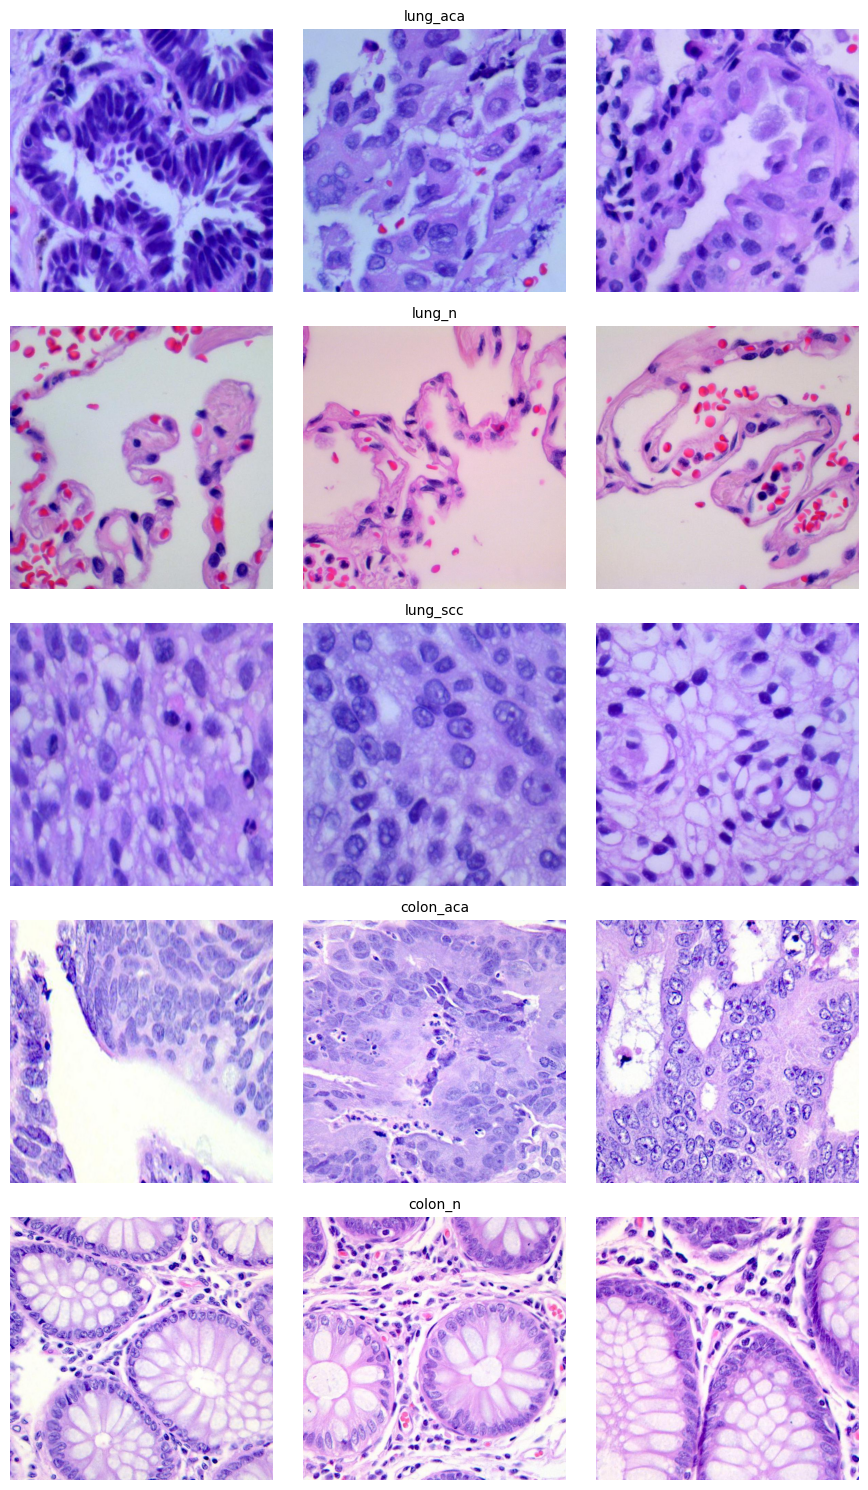

In [8]:
# Input image display
import matplotlib.pyplot as plt
import random

def show_samples(df, class_names, samples_per_class=3):
    plt.figure(figsize=(samples_per_class * 3, len(class_names) * 3))
    for row, cname in enumerate(class_names):
        cdf = df[df["label"] == class_names.index(cname)]
        chosen = cdf.sample(n=samples_per_class, random_state=SEED)
        for col, (_, r) in enumerate(chosen.iterrows()):
            img = Image.open(r["path"]).convert("RGB")
            ax = plt.subplot(len(class_names), samples_per_class, row * samples_per_class + col + 1)
            plt.imshow(img)
            plt.axis("off")
            if col == samples_per_class // 2:
                ax.set_title(cname, fontsize=10)
    plt.tight_layout()
    plt.show()

# Show training set samples
show_samples(train_df, CLASS_NAMES, samples_per_class=3)

In [9]:
# Model VGG16
# Augmentation + preprocess
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
    layers.RandomBrightness(0.10),
    layers.GaussianNoise(0.02),
], name="augmentation")

preprocess_layer = layers.Lambda(lambda t: vgg_preprocess(t), name="vgg16_preprocess")

def build_model(input_shape=(224,224,3), num_classes=5):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_layer(x)

    vgg_base = VGG16(include_top=False, weights="imagenet", input_shape=input_shape, name="vgg16")
    vgg_base.trainable = False
    x = vgg_base(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    model = keras.Model(inputs, outputs, name="vgg16_transfer")
    return model, vgg_base

model, vgg_base = build_model(input_shape=IMG_SIZE + (3,), num_classes=len(CLASS_NAMES))
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_preprocess (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,909 (57.14 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Train head (frozen base)
ckpt_head = str(OUT_DIR / "vgg16_head_best.keras")
callbacks_head = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint(ckpt_head, monitor="val_loss", save_best_only=True),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
history_head = model.fit(train_ds, validation_data=val_ds,
                         epochs=EPOCHS_HEAD, callbacks=callbacks_head, verbose=1)

Epoch 1/8


I0000 00:00:1755017710.284541      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


565/565 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - acc: 0.8808 - loss: 0.7353 - val_acc: 0.8743 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 2/8
565/565 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - acc: 0.9259 - loss: 0.2666 - val_acc: 0.8916 - val_loss: 0.3310 - learning_rate: 0.0010
Epoch 3/8
565/565 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - acc: 0.9317 - loss: 0.2458 - val_acc: 0.9354 - val_loss: 0.2317 - learning_rate: 0.0010
Epoch 4/8
565/565 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - acc: 0.9353 - loss: 0.2342 - val_acc: 0.9179 - val_loss: 0.2595 - learning_rate: 0.0010
Epoch 5/8
565/565 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - acc: 0.9341 - loss: 0.2337 - val_acc: 0.9307 - val_loss: 0.2227 - learning_rate: 0.0010
Epoch 6/8
565/565 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - acc: 0.9422 - loss: 0.2093 - val_acc: 0.9317 - val_loss: 0.2350 - learning_rate: 0.0010
Epoch 7/8
565/565 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - acc: 0.9408 - loss: 0.2115 - val_acc: 0.9423 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 8/8

In [11]:
# Fine tune top VGG16 layers
for layer in vgg_base.layers[-UNFREEZE_AT:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
print(f"Unfroze top {UNFREEZE_AT} VGG16 layers.")

model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
ckpt_ft = str(OUT_DIR / "vgg16_finetune_best.keras")
callbacks_ft = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7),
    keras.callbacks.ModelCheckpoint(ckpt_ft, monitor="val_loss", save_best_only=True),
]
history_ft = model.fit(train_ds, validation_data=val_ds,
                       epochs=EPOCHS_FT, callbacks=callbacks_ft, verbose=1)

Unfroze top 5 VGG16 layers.
Epoch 1/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 58s 95ms/step - acc: 0.9538 - loss: 0.2134 - val_acc: 0.9652 - val_loss: 0.1344 - learning_rate: 3.0000e-05
Epoch 2/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - acc: 0.9743 - loss: 0.1252 - val_acc: 0.9618 - val_loss: 0.1350 - learning_rate: 3.0000e-05
Epoch 3/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - acc: 0.9815 - loss: 0.0953 - val_acc: 0.9884 - val_loss: 0.0716 - learning_rate: 3.0000e-05
Epoch 4/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - acc: 0.9800 - loss: 0.1082 - val_acc: 0.9919 - val_loss: 0.0614 - learning_rate: 3.0000e-05
Epoch 5/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - acc: 0.9893 - loss: 0.0666 - val_acc: 0.9825 - val_loss: 0.0805 - learning_rate: 3.0000e-05
Epoch 6/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - acc: 0.9903 - loss: 0.0703 - val_acc: 0.9868 - val_loss: 0.0716 - learning_rate: 3.0000e-05
Epoch 7/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - acc: 0.9909 - loss: 0.0598 -

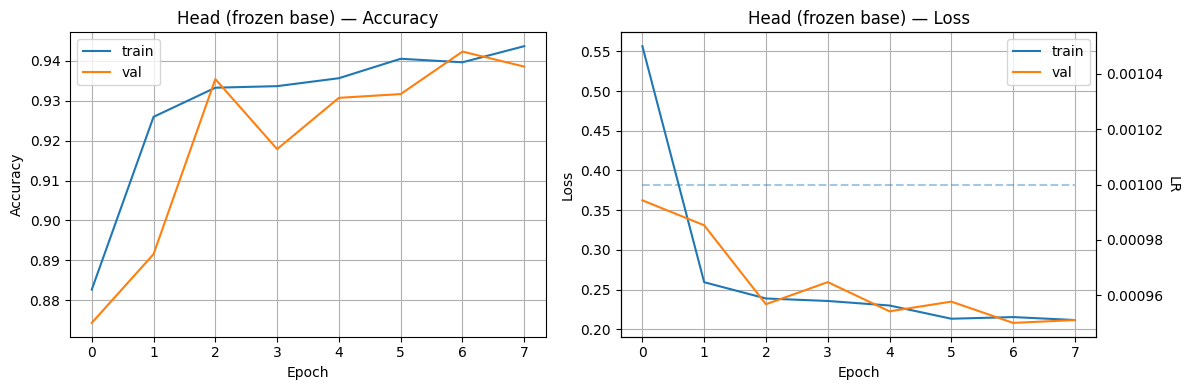

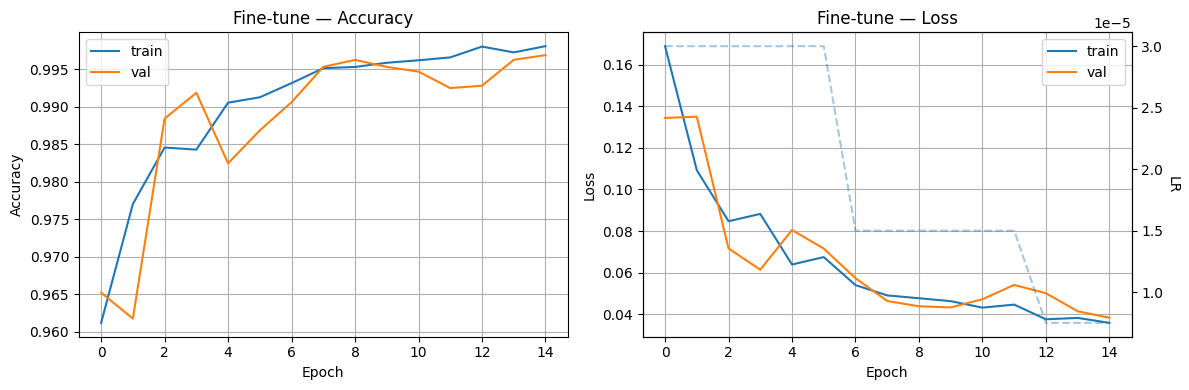

In [12]:
# Plots
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history, title="Training"):
    hist = pd.DataFrame(history.history)
    # common aliases for learning rate in History
    lr_key = "learning_rate" if "learning_rate" in hist else ("lr" if "lr" in hist else None)

    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    if "acc" in hist:         # SparseCategoricalAccuracy(name="acc")
        plt.plot(hist["acc"], label="train")
        if "val_acc" in hist: plt.plot(hist["val_acc"], label="val")
        plt.ylabel("Accuracy"); plt.xlabel("Epoch"); plt.title(f"{title} — Accuracy"); plt.legend(); plt.grid(True)
    elif "accuracy" in hist:
        plt.plot(hist["accuracy"], label="train")
        if "val_accuracy" in hist: plt.plot(hist["val_accuracy"], label="val")
        plt.ylabel("Accuracy"); plt.xlabel("Epoch"); plt.title(f"{title} — Accuracy"); plt.legend(); plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist["loss"], label="train")
    if "val_loss" in hist: plt.plot(hist["val_loss"], label="val")
    plt.ylabel("Loss"); plt.xlabel("Epoch"); plt.title(f"{title} — Loss"); plt.legend(); plt.grid(True)

    if lr_key is not None:
        ax = plt.gca().twinx()
        ax.plot(hist[lr_key], alpha=0.4, linestyle="--")
        ax.set_ylabel("LR", rotation=270, labelpad=12)

    plt.tight_layout()
    plt.show()

# Call these if you kept both histories
plot_history(history_head, "Head (frozen base)")
plot_history(history_ft,   "Fine‑tune")

Test metrics: {'loss': 0.0353819765150547, 'compile_metrics': 0.9983987212181091}

Classification Report (Test):
              precision    recall  f1-score   support

    lung_aca     1.0000    0.9920    0.9960       747
      lung_n     1.0000    1.0000    1.0000       747
    lung_scc     0.9948    1.0000    0.9974       758
   colon_aca     0.9973    1.0000    0.9987       745
     colon_n     1.0000    1.0000    1.0000       750

    accuracy                         0.9984      3747
   macro avg     0.9984    0.9984    0.9984      3747
weighted avg     0.9984    0.9984    0.9984      3747



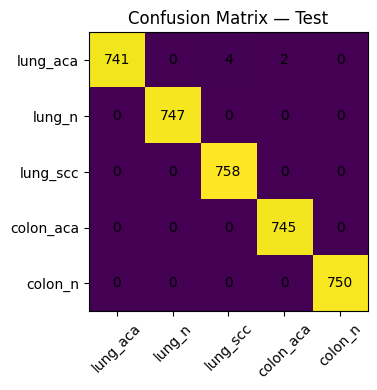

In [13]:
# Evaluate on test set
print("Test metrics:", dict(zip(model.metrics_names, model.evaluate(test_ds, verbose=0))))

from sklearn.metrics import classification_report, confusion_matrix
y_true, y_pred = [], []
for x, y in test_ds:
    probs = model.predict(x, verbose=0)
    y_true.extend(y.numpy().tolist())
    y_pred.extend(probs.argmax(axis=1).tolist())

print("\nClassification Report (Test):")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix — Test")
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=45)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.tight_layout(); plt.show()